In [1]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm

In [2]:
video_name = 'Help'
data = pd.read_fwf('data/head_tracking_data/Subject_1/' + video_name + '.txt', header=None)

data.columns = ['latitude', 'longitude']

cap = cv2.VideoCapture('data/video_files/' + video_name + '.mp4')

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

calc_mod = round(1/(round((length/len(data)),2)-1))

In [3]:
# Converting longitude/latitude coordinates to mercator zones
lst = []
for i in range(len(data)):
    u = utm.from_latlon(data.iloc[i].latitude, data.iloc[i].longitude)
    lst.append(u[2:]) # from 2nd column because those are the zones we're interested in
    
xy = pd.DataFrame(lst)    

In [7]:
# concatenate zones and zone bands to dataframe
coords = pd.concat([data, xy],axis=1)
coords.columns = ['latitude', 'longitude', 'zone', 'band']

In [8]:
# convert letters to numbers - issue exists because mercator zones omit the letters "I" and "O"
coords['n_band'] = [ ord(x) - 64 for x in coords.band ]

In [9]:
coords.describe()

,latitude,longitude,zone,n_band
count,618.000000,618.000000,618.000000,618.000000
mean,4.732776,70.366402,42.283172,14.220065
std,4.894504,45.374838,7.570677,0.898469
min,-11.558613,-67.861549,19.000000,12.000000
25%,2.090104,50.828335,39.000000,14.000000
50%,5.255124,89.956080,45.000000,14.000000
75%,7.704092,93.738930,46.000000,14.000000
max,15.275564,152.665727,56.000000,16.000000


In [24]:
# Probably here we can work out the size of a tile
bins_zone = [i*15 for i in range(1,5)]
labels_zone = [i for i in range(1,4)]

bins_band = [i*6 for i in range(1,5)]
labels_band = [i for i in range(1,4)]

# # binning results
coords['bin_zone'] = pd.DataFrame(pd.cut(coords['zone'], bins=bins_zone, labels=labels_zone))
coords['label_zone'] = pd.DataFrame(pd.cut(coords['n_band'], bins=bins_band, labels=labels_band))

In [25]:
coords[['bin_zone' , 'label_zone']].head(3)

,bin_zone,label_zone
0,2,2
1,2,2
2,2,2


In [33]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl


G = nx.DiGraph()
for i in range(len(coords)-1):
    # connect previous zone to the next one
    G.add_edge((coords.iloc[i]['bin_zone'], coords.iloc[i]['label_zone']), (coords.iloc[i+1]['bin_zone'], coords.iloc[i+1]['label_zone']))
    

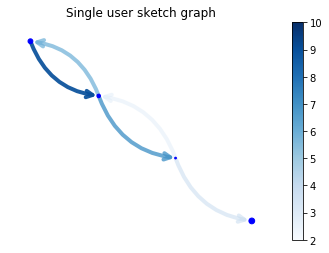

In [66]:
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    connectionstyle="arc3,rad=0.3",
    width=4,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(p)
ax = plt.gca()
ax.set_axis_off()
plt.title('Single user sketch graph')
plt.show()
